## Forecasting Homework
### Homework done by Eimantas Vengris

Today is 2012-12-10. You are a Data Scientist at a large US publicly traded retailer.
Before the end of the year the Chief Financial Officer (CFO) needs to put out a financial
forecast for the coming calendar year (2013) to comply with regulations, and to
inform shareholders of expected business performance. You have been asked to
provide these forecasts. You have 1 week as people are going on Christmas holiday
on 2012-12-17, and the CFO wants some time to look over the forecasts and make
sure they are ok.
You have been provided with 3 files; features.csv, sales.csv, stores.csv, which contain
data about retail sales.

### Tasks

- Analyse data, identify key drivers (features) for sales success (mandatory task).
- Prepare suggestions to CFO on how to improve sales for the next year (mandatory
task).
- Predict next year's (2012-12-10 to 2013-12-10) weekly sales (task for bonus
points).

## Project Structure
* Data loading, cleaning and preperation operations
* Exploratory data analysis
    * Store sales analysis
    * Time Series of all stores combined weekly sales and features
    * Corelation analysis
* Forecast
* Conclusions

In [2]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
# Version check for imports
print("NumPy", np.__version__)
print("Pandas", pd.__version__)
print("Sklearn", sklearn.__version__)

NumPy 1.19.2
Pandas 1.1.3
Sklearn 0.23.2


## Data loading, cleaning and preperation operations

First of all, all data table will be loaded into the dataframes and merged together into one dataframe accoring to their relations with each other. 

In [4]:
features_df = pd.read_csv('Forecasting FuturePros/features.csv')
sales_df = pd.read_csv('Forecasting FuturePros/sales.csv')
stores_df = pd.read_csv('Forecasting FuturePros/stores.csv')

It would be best to group the data of the sales_df by Date 

In [5]:
# Inner join of Sales and Stores dataframes
temp_df = pd.merge(sales_df, stores_df, on='Store')

In [6]:
# Left join of the Temporary dataframe with Features dataframe
merged_df = pd.merge(temp_df, features_df, on=['Store', 'Date'], how='left')

In [7]:
# Change the type of fdate column to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort the data by date to prepare data for plotting
merged_df.sort_values('Date', inplace=True)

# Reset indexes
merged_df= merged_df.reset_index(drop=True)

# Replace 'NaN values with np.nan'
merged_df.replace('NaN', np.nan, inplace=True)

# Create a copy of merged_df for corelation matrix
copy_merged_df = merged_df.copy()


Check the describtion of the dataframe to check general information such as collumns with missing entries.

From this describtion it can bee seen that only MarkDown columns have missing values which makes sence since Markdowns - promotion discounts, only available after November 11 2010 and may not exist for every row.

However, MarkDown values might have influence to weekly sales therefore, they will have to be accounted.

It is not mentioned exactely in the task what each MarkDown is representing and additional information could help to better evaluete their effect and give conclusions.

In [8]:
merged_df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [9]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,33,96,2010-01-10,7854.09,False,A,39690,91.45,3.001,NaN,NaN,NaN,NaN,NaN,126.234600,9.265,False
1,17,93,2010-01-10,3533.76,False,B,93188,60.07,2.853,NaN,NaN,NaN,NaN,NaN,126.234600,6.885,False
2,30,85,2010-01-10,43.92,False,C,42988,70.28,2.603,NaN,NaN,NaN,NaN,NaN,211.329874,8.163,False
3,30,87,2010-01-10,119.80,False,C,42988,70.28,2.603,NaN,NaN,NaN,NaN,NaN,211.329874,8.163,False
4,9,55,2010-01-10,6795.58,False,B,125833,69.08,2.603,NaN,NaN,NaN,NaN,NaN,215.214134,6.560,False


In [10]:
merged_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
421565,1,82,2012-12-10,21963.11,False,A,151315,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573,False
421566,9,81,2012-12-10,2526.96,False,B,125833,60.09,3.601,520.41,NaN,6.01,NaN,2839.84,227.169392,4.954,False
421567,19,7,2012-12-10,27983.12,False,A,203819,48.29,4.186,2374.50,NaN,7.25,919.32,6101.00,138.911700,7.992,False
421568,2,95,2012-12-10,145394.36,False,A,202307,60.97,3.601,2145.50,NaN,33.31,586.83,10421.01,223.015426,6.170,False
421569,18,91,2012-12-10,26275.85,False,B,120653,50.97,4.029,2241.19,NaN,30.08,901.32,3592.56,138.911700,8.243,False


## Exploratory data analysis

In this section of the project, key drivers will be identified by exploring combined data and checking for collerations between weekly sales and available features.
The analysis will be carried out in an explaratory manner by ploting data and answering bussiness related questions.

### Store sales analysis

In this paragraph individual stores sales performances will be analysed such as:
* Which stores had highes sales?
* What may have influenced the results?

In [11]:
# Add years column
merged_df['Year'] = merged_df['Date'].dt.year

In [12]:
# Yearly total sales
merged_df.groupby('Year')['Weekly_Sales'].sum()

Year
2010    2.288886e+09
2011    2.448200e+09
2012    2.000133e+09
Name: Weekly_Sales, dtype: float64

In [13]:
# Group by data by Date and Type to extract yearly sales of each type of store
dates_grp = merged_df.groupby(['Date', 'Type'])['Weekly_Sales'].sum()

# Year's of intrest
years_filter = ['2010', '2011', '2012']

yearly_sales = []
for year in years_filter:
    yearly_sales.append(dates_grp.unstack().loc[year].sum())
# Convert yearly sales to array
yearly_sales = np.array(yearly_sales)
# SUm up total sales for each type of store
total_sales = np.sum(yearly_sales, axis=0)

The graph below shows the sales of each type of store during the years 2010, 2011, 2012 as well as the total sales during the years. It is important to note that not all date from the year 2012 is available.

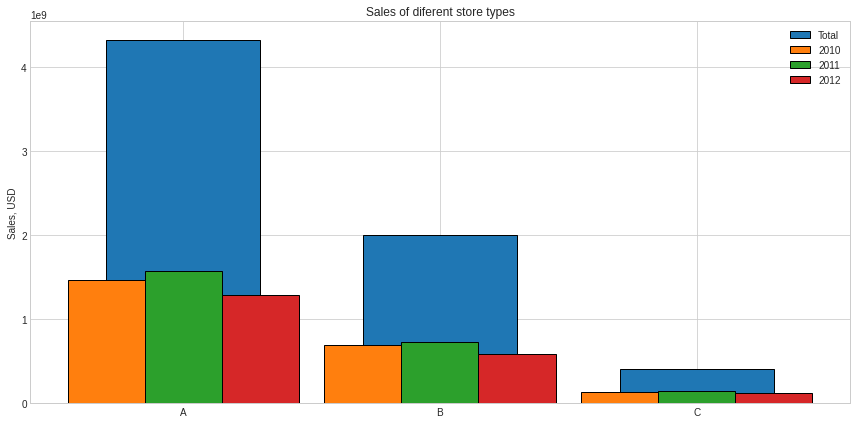

In [15]:
yearly_sales = np.array(yearly_sales)
total_sales = np.sum(yearly_sales, axis=0)
fig, ax1 = plt.subplots(figsize=(12,6))
labels = ['A', 'B', 'C']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

ax1.bar(x, total_sales, width*2, label='Total', edgecolor='black')
ax1.bar(x - width, yearly_sales[0], width, label='2010', edgecolor='black')
ax1.bar(x , yearly_sales[1], width, label='2011', edgecolor='black')
ax1.bar(x + width , yearly_sales[2], width, label='2012', edgecolor='black')

ax1.set_ylabel('Sales, USD')
ax1.set_title('Sales of diferent store types')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()


fig.tight_layout()
plt.show()

Grouping by store type to determine the influence factors of the sales

* How many stores of each type exist.
* The avrage size of each store.
* The total size of each store type.
* Standard deviation of size of each store type.
* The total size of each stores type.
* The range of the size (Min, Max)

In [39]:
store_aggregation_function = {'Store':'count',
                              'Size':[min, max, sum, np.mean, np.std]}
store_types_df = stores_df.groupby('Type').agg(store_aggregation_function)

store_types_df.columns = store_types_df.columns.droplevel(0)

In [40]:
# Add total sales column to compare total size vs sales
store_types_df['Total Sales'] = total_sales

# Rename columns
store_types_df.rename(columns={'count':'Store Count', 
                   'min':'Store Size Min',
                   'max':'Store Size Max',
                   'mean':'Store Size Mean',
                   'sum':'Store Size Total',
                   'std':'Store Size std'}, inplace=True)

In [41]:
# Normalize Total Size and Total Sales for comparison
store_types_df['Total Sales Normalized'] = (store_types_df['Total Sales'] / store_types_df['Total Sales'].sum()) * 100
store_types_df['Total Size Normalized'] = (store_types_df['Store Size Total'] / store_types_df['Store Size Total'].sum()) * 100

In [42]:
store_types_df

,Store Count,Store Size Min,Store Size Max,Store Size Total,Store Size Mean,Store Size std,Total Sales,Total Sales Normalized,Total Size Normalized
Type,,,,,,,,,
A,22,39690,219622,3899450,177247.727273,49392.621098,4.331015e+09,64.284903,66.510124
B,17,34875,140167,1720242,101190.705882,32371.137916,2.000701e+09,29.696240,29.340935
C,6,39690,42988,243250,40541.666667,1304.145033,4.055035e+08,6.018856,4.148941


After normalizing the values of total sales and total size of the stores it can be seen that total sales ar realted to the size of the stores.

In [43]:
# Combined results and features
aggregation_functions = {'Weekly_Sales':sum, 
                         'Temperature':'mean', 
                         'Fuel_Price':'mean', 
                         'CPI':'mean', 
                         'Unemployment':'mean',
                         'MarkDown1':'first',
                         'MarkDown2':'first',
                         'MarkDown3':'first',
                         'MarkDown4':'first'
                        ,'MarkDown5':'first'}
dates_grp = merged_df.groupby(['Date']).aggregate(aggregation_functions)
dates_grp

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,,,,,,
2010-01-10,42239875.87,69.386998,2.733064,168.004935,8.433960,NaN,NaN,NaN,NaN,NaN
2010-02-04,50423831.26,52.587887,2.825453,167.377836,8.441092,NaN,NaN,NaN,NaN,NaN
2010-02-07,48917484.50,76.555955,2.793190,167.663264,8.373801,NaN,NaN,NaN,NaN,NaN
2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,NaN,NaN,NaN,NaN,NaN
2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2012-10-08,47403451.04,81.164112,3.633858,175.378772,7.224676,11811.65,26.00,59.03,2215.73,2801.89
2012-10-19,45122410.57,60.152756,3.878413,176.295499,6.948928,37.11,NaN,0.15,1406.03,1030.33
2012-10-26,45544116.29,60.530277,3.791086,176.182886,6.943212,10768.84,50.54,104.50,345.37,6629.51


### Time Series of all stores combined weekly sales and features

In this paragraph combined weekle sales and other features combined are plotted to visually analyze their influence to sales.
From the first glimpse it can be seen that there is a seasonality during christmas period with highly increased sales.The rest of the year is with rather stable oscillations. And by looking at the featue plots it is hard to dertermine weather they have an effetc or not. As a result, it is a good idea to try other analysis tools such as covariance, colleration which will be done in the next step.

##### To get better insights it wold be better to analyze each store and its feature individually, but in order not to expand too much I will be looking in a bigpicture rather than individual cases!!

In [44]:
# Combined results and features
aggregation_functions = {'Weekly_Sales':sum, 
                         'Temperature':'mean', 
                         'Fuel_Price':'mean', 
                         'CPI':'mean', 
                         'Unemployment':'mean',
                         'MarkDown1':'first',
                         'MarkDown2':'first',
                         'MarkDown3':'first',
                         'MarkDown4':'first'
                        ,'MarkDown5':'first'}
dates_grp = merged_df.groupby(['Date']).aggregate(aggregation_functions)
dates_grp

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,,,,,,
2010-01-10,42239875.87,69.386998,2.733064,168.004935,8.433960,NaN,NaN,NaN,NaN,NaN
2010-02-04,50423831.26,52.587887,2.825453,167.377836,8.441092,NaN,NaN,NaN,NaN,NaN
2010-02-07,48917484.50,76.555955,2.793190,167.663264,8.373801,NaN,NaN,NaN,NaN,NaN
2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,NaN,NaN,NaN,NaN,NaN
2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2012-10-08,47403451.04,81.164112,3.633858,175.378772,7.224676,11811.65,26.00,59.03,2215.73,2801.89
2012-10-19,45122410.57,60.152756,3.878413,176.295499,6.948928,37.11,NaN,0.15,1406.03,1030.33
2012-10-26,45544116.29,60.530277,3.791086,176.182886,6.943212,10768.84,50.54,104.50,345.37,6629.51


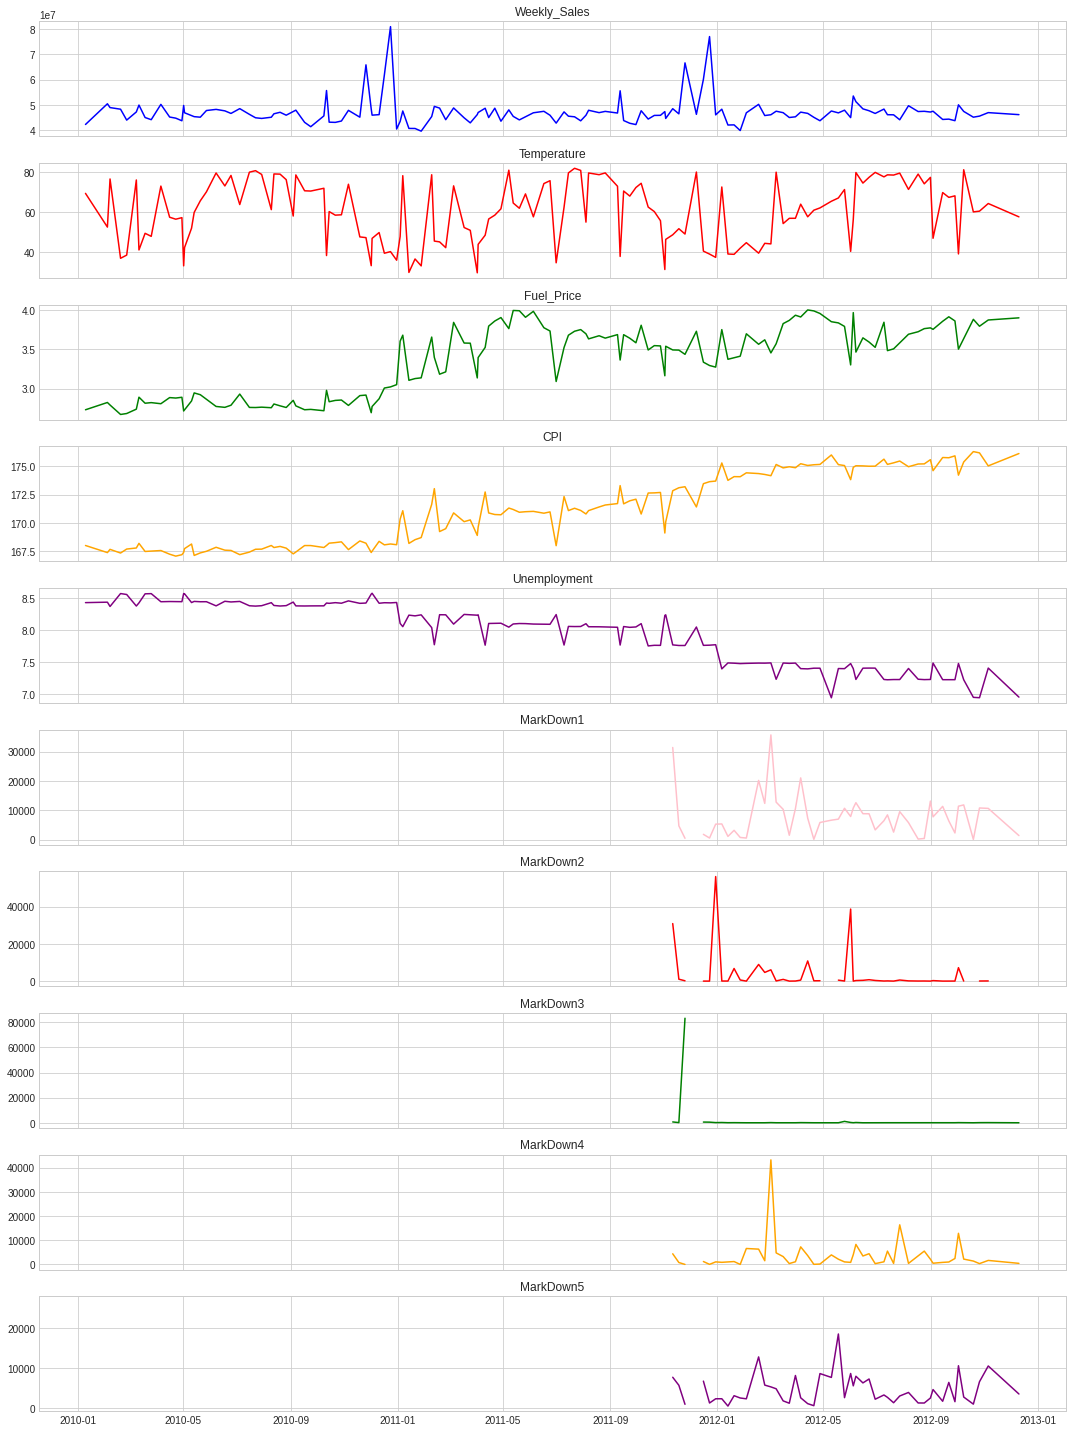

In [45]:
# Get columns list from the grouped dataframe
dates_grp_columns = dates_grp.columns.tolist()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'red', 'green', 'orange', 'purple', 'pink']

fig, ax = plt.subplots(len(dates_grp_columns), 1, figsize=(15,20), sharex=True)
for n, column in enumerate(dates_grp_columns):

    ax[n].plot( dates_grp.index, dates_grp[column], color=colors[n] )
    ax[n].set_title(column)
    plt.tight_layout()
    
plt.show()



## Corelation analysis

In this section corelation is going to be analysed to determine key drivers of weekly sales
Markdown are seperated from other features in scatter matrix plots since they only started to occur from the beggining of the year 2012. For that reason it is best to check their plots during year 2012 and keep the corelation matrix as it is.

Colleration Matrix

In [46]:
# Including Markdowns just to see the result
dates_grp.corr()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Weekly_Sales,1.000000,-0.158603,-0.056371,0.027008,0.003443,-0.088121,-0.095854,0.455434,-0.070149,0.016601
Temperature,-0.158603,1.000000,0.205794,0.152310,-0.167136,-0.034988,-0.391979,-0.111637,-0.055428,-0.193502
Fuel_Price,-0.056371,0.205794,1.000000,0.824648,-0.750892,-0.032925,-0.375860,-0.160620,-0.151153,-0.123907
CPI,0.027008,0.152310,0.824648,1.000000,-0.976885,-0.111566,-0.386747,-0.275753,-0.057997,-0.270192
Unemployment,0.003443,-0.167136,-0.750892,-0.976885,1.000000,0.083282,0.350899,0.250800,-0.010751,0.227514
MarkDown1,-0.088121,-0.034988,-0.032925,-0.111566,0.083282,1.000000,0.221252,-0.145869,0.628629,0.244788
MarkDown2,-0.095854,-0.391979,-0.375860,-0.386747,0.350899,0.221252,1.000000,-0.047557,0.021854,0.050020
MarkDown3,0.455434,-0.111637,-0.160620,-0.275753,0.250800,-0.145869,-0.047557,1.000000,-0.077566,-0.099400
MarkDown4,-0.070149,-0.055428,-0.151153,-0.057997,-0.010751,0.628629,0.021854,-0.077566,1.000000,0.091020
MarkDown5,0.016601,-0.193502,-0.123907,-0.270192,0.227514,0.244788,0.050020,-0.099400,0.091020,1.000000


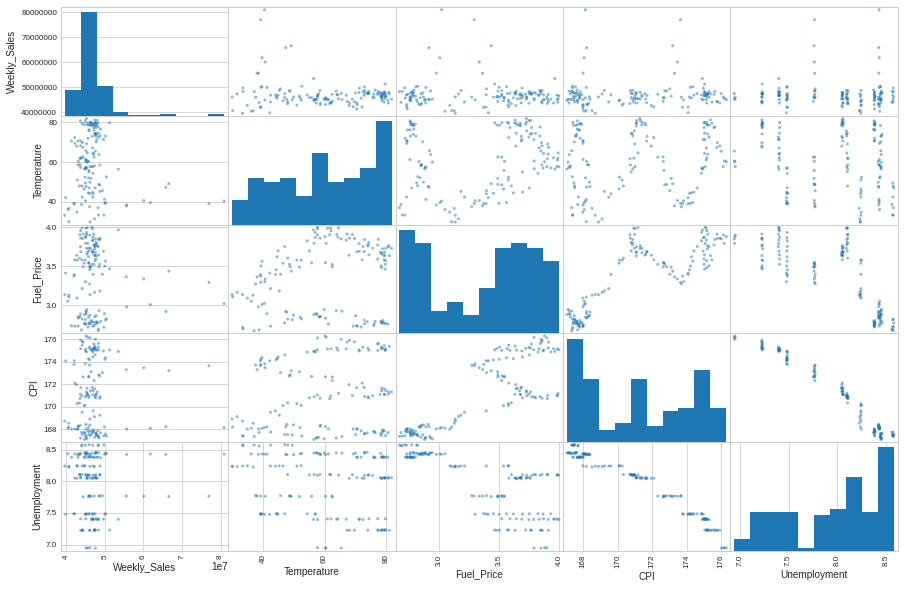

In [47]:
from pandas.plotting import scatter_matrix
atributes = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
scatter_matrix(dates_grp[atributes], figsize=(15,10))
plt.show()

In [48]:
dates_grp['2012'][markdown_atributes].corr()

NameError: name 'markdown_atributes' is not defined

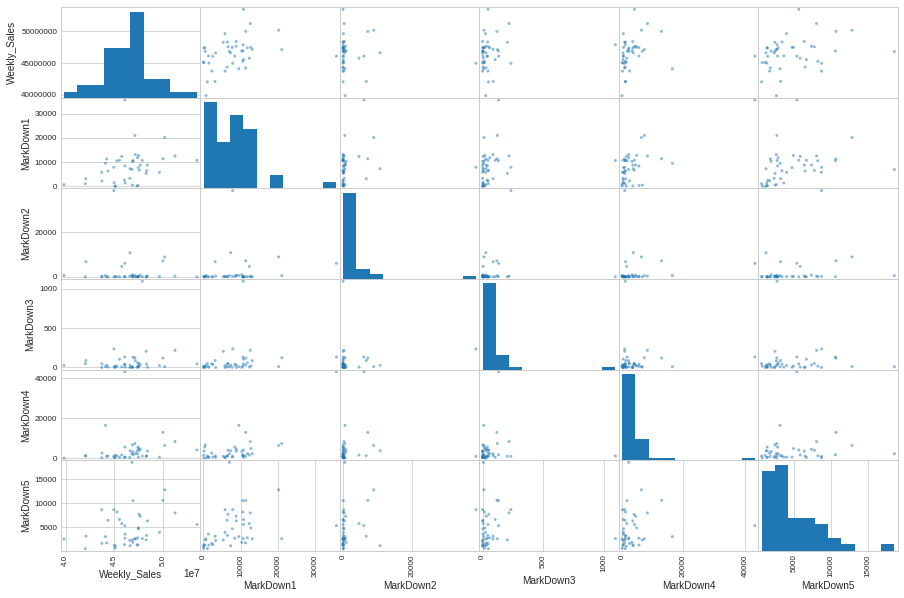

In [49]:
markdown_atributes = ['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
scatter_matrix(dates_grp['2012'][markdown_atributes], figsize=(15,10))
plt.show()

## Forcasting Multiplicative Decomposition

In [50]:
# Creation of new dataframe jand resampling with one week frequency
# Since the month 2012-12 is not complete I am not going to include it
sales_df = dates_grp[:'2012-11-05']['Weekly_Sales'].to_frame().resample('W').sum()

# Creating a time point
sales_df_ts = sales_df.reset_index()

# Adding week of the year
sales_df_ts['Week_Number'] = sales_df_ts['Date'].dt.isocalendar().week

# Smooth out the data by taking out seasonal and iregular components
sales_df_ts['Rolling Avrage'] = sales_df_ts['Weekly_Sales'].rolling(window=12).mean()

#### Step I Plotting the Time Series

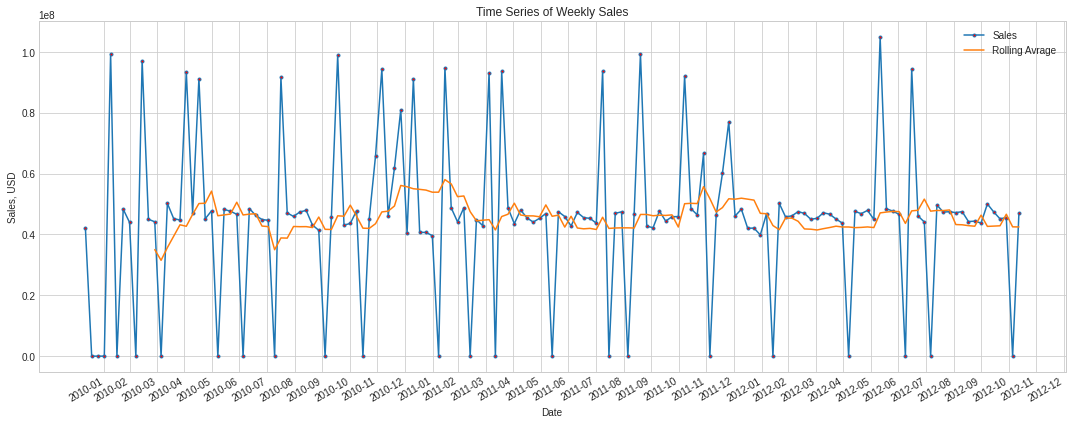

In [51]:
from matplotlib import dates as mpl_dates

x_tickers = pd.date_range(merged_df['Date'].min(), '2013-01-01', freq='1M').tolist()
x_date = sales_df.index
y_sales = sales_df['Weekly_Sales']

fig, ax = plt.subplots(figsize=(15,6))
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%Y-%m'))
ax.plot_date(x_date, y_sales, label='Sales', linestyle='solid', markersize=3, markerfacecolor ='red')
ax.plot_date(x_date, sales_df_ts['Rolling Avrage'], 
             label='Rolling Avrage', 
             linestyle='solid', markersize=0, 
             markerfacecolor ='red')

ax.set_ylabel('Sales, USD')
ax.set_xlabel('Date')
ax.set_title('Time Series of Weekly Sales')
ax.set_xticks(x_tickers)
ax.legend()

plt.tight_layout()
plt.show()


In [52]:
# Seasonal componnnetn and irregular componnent
sales_df_ts['St_Yt'] = sales_df_ts['Weekly_Sales']/sales_df_ts['Rolling Avrage']

In [53]:
# Quantify just the seasonal componnent
st_group = sales_df_ts.groupby('Week_Number')['St_Yt'].mean()
# Merge st_group back together with sales_df_ts
sales_df_ts = pd.merge(sales_df_ts, st_group, on='Week_Number').sort_values(by=['Date'])

In [54]:
# Clean uop the dataframe
sales_df_ts.rename(columns={'St_Yt_y':'St',
                            'St_Yt_x':'St_Yt'}, inplace=True)
sales_df_ts.index = np.arange(1, len(sales_df_ts) + 1)
sales_df_ts['t'] = sales_df_ts.index

In [55]:
# Deseasonalize
sales_df_ts['Deseasonalize'] = sales_df_ts['Weekly_Sales']/sales_df_ts['St']

In [56]:
# Trend component Tt
# Apply linear regression model to our data to get the coeficients
from sklearn.linear_model import LinearRegression

x = sales_df_ts.index.to_numpy().reshape(-1, 1)
y = sales_df_ts['Deseasonalize'].to_numpy().reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [45797480.77740911]
slope: [[6768.33247017]]


In [57]:
# Linear Regression Fit
sales_df_ts['Tt'] = sales_df_ts['t'].apply(lambda x : model.intercept_[0] + model.coef_[0][0] * x)

In [58]:
# Forecast
sales_df_ts['Forecast'] = sales_df_ts['St']*sales_df_ts['Tt']

In [59]:
dates_forcast = pd.date_range(sales_df_ts['Date'].max(), freq='W', periods=56)
dates_forcast = pd.DataFrame(dates_forcast, columns = ['Date'])[1:]

In [60]:
# Append dates for forecasting
sales_df_ts_forcasting = sales_df_ts.append(dates_forcast, ignore_index=True)

# Add weeks of the year
sales_df_ts_forcasting['Week_Number'] = sales_df_ts_forcasting['Date'].dt.isocalendar().week

# Drop St and merge with new one
sales_df_ts_forcasting.drop(columns='St', inplace=True)
sales_df_ts_forcasting = pd.merge(sales_df_ts_forcasting, st_group, on='Week_Number').sort_values(by=['Date'])

# Clean uop the dataframe
sales_df_ts_forcasting.rename(columns={'St_Yt_y':'St',
                            'St_Yt_x':'St_Yt'}, inplace=True)

sales_df_ts_forcasting.index = np.arange(1, len(sales_df_ts_forcasting) + 1)
sales_df_ts_forcasting['t'] = sales_df_ts_forcasting.index

In [61]:
# Extend linear regression values
sales_df_ts_forcasting['Tt'] = sales_df_ts_forcasting['t'].apply(lambda x : model.intercept_[0] + model.coef_[0][0] * x)

# Extend forecast
# Forecast
sales_df_ts_forcasting['Forecast'] = sales_df_ts_forcasting['St']*sales_df_ts_forcasting['Tt']

### Plotting TimeSeries With Forecast

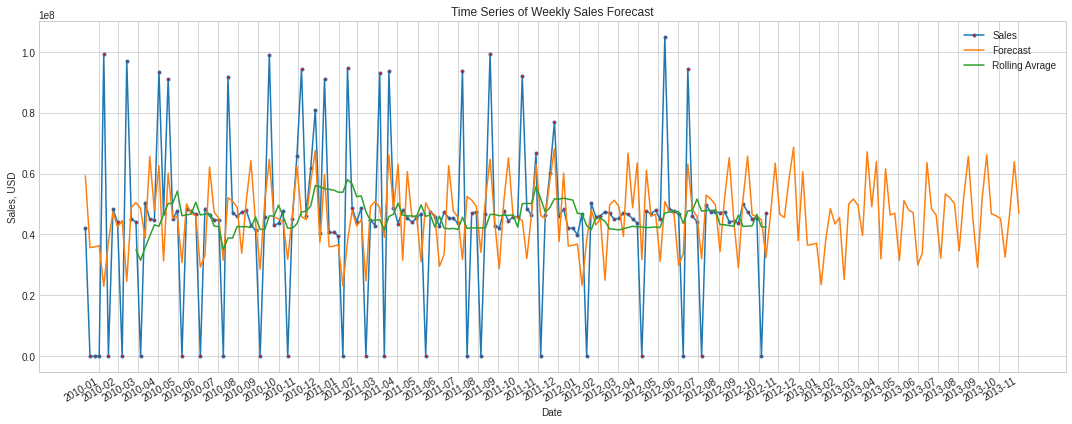

In [62]:
x_tickers = pd.date_range(sales_df_ts_forcasting['Date'].min(), 
                          sales_df_ts_forcasting['Date'].max(), 
                          freq='1M').tolist()

x_date = sales_df_ts_forcasting['Date']
y_sales = sales_df_ts_forcasting['Weekly_Sales']
y_forecast_sales = sales_df_ts_forcasting['Forecast']

fig, ax = plt.subplots(figsize=(15,6))
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%Y-%m'))
ax.plot_date(x_date, y_sales, label='Sales', linestyle='solid', markersize=3, markerfacecolor ='red')
ax.plot_date(x_date, y_forecast_sales, label='Forecast', linestyle='solid', markersize=0)
ax.plot_date(x_date, sales_df_ts_forcasting['Rolling Avrage'], label='Rolling Avrage', 
                                 linestyle='solid', markersize=0, markerfacecolor ='red')

ax.set_ylabel('Sales, USD')
ax.set_xlabel('Date')
ax.set_title('Time Series of Weekly Sales Forecast')
ax.set_xticks(x_tickers)
ax.legend()

plt.tight_layout()
plt.show()

In [63]:
# Predicted total sales for year 2013
filt =  (sales_df_ts_forcasting['Date'] > '2013-01-01')
sales_df_ts_forcasting[filt]['Forecast'].sum()

2214282972.1047664

## Conclusions and Suggestions

### Key Drivers
During th exploratory analysis some relationships between sales and external and internal features have been found. Most of the correlations are weak but they might have an effect on sales. To be more clear it would be a good idea to analyze the stores individually rather than combining all of their data together. 

To summarize the results features such as **Fuel price**, **CPI** and **unemployment rates** had no realtion ship to the weekly sales. The avrage **temperature** also doesn't show any strong relationship, but analyzing individual cases might proove diffrent.

There has to be seperate analysis done for markdowns since they only appeared from 2012. And in summary all of them except **MarkDown2** have A weak positive relationship.

While analyzing sales time series the seasional spikes during December were very noticable. However, as they years passed the holiday spike together with the total yearly sales has droped. the reson for that should be further analyzed and other factors should be taken into account (Competition, outdated product, lack of advertisment or other).

Forcasting does not suggest results similar to the year 2011. However other forecasting model should be reviewd, or other forecasting models applied.